In [20]:
import pandas as pd
import geopandas as gpd
import numpy as np 
import matplotlib.pyplot as plt 
import os
import fiona
import re

<AxesSubplot:>

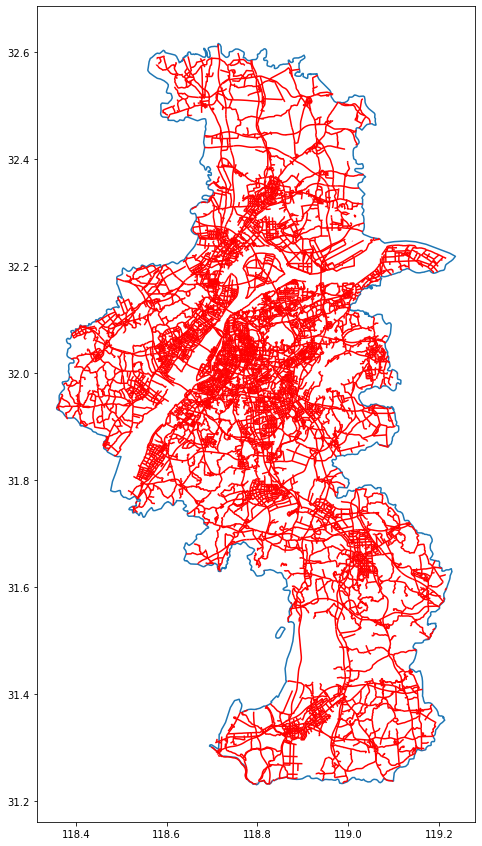

In [2]:
# gdf = gpd.read_file('./data/None_road_320100_2022_.geojson')
# gdf_b = gpd.read_file('../boundary_city_amap/data/amap_boundary_city_320100_2022_.geojson')
# f, ax = plt.subplots(figsize=(15,15))
# gdf_b['geometry'].boundary.plot(ax=ax)
# gdf.plot(ax=ax, color='r')

In [2]:
target_cities_dict = {
 '110100':'beijing',
 '120100':'tianjin',
 '130100':'shijiazhuang',
 '130200':'tangshan',
 '140100':'taiyuan',
 '140500':'jincheng',
 '150100':'huhehaote',
 '150200':'baotou',
 '210100':'shenyang',
 '210200':'dalian',
 '220100':'changchun',
 '220300':'siping',
 '230100':'haerbin',
 '230600':'daqing',
 '310100':'shanghai',
 '320100':'nanjing',
 '320200':'wuxi',
 '320300':'xuzhou',
 '320400':'changzhou',
 '320500':'suzhou',
 '330100':'hangzhou',
 '330200':'ningbo',
 '330300':'wenzhou',
 '330400':'jiaxing',
 '330600':'shaoxing',
 '330800':'quzhou',
 '340100':'hefei',
 '340200':'wuhu',
 '341600':'bozhou',
 '350100':'fuzhou',
 '350200':'xiamen',
 '360100':'nanchang',
 '360200':'jingdezhen',
 '360700':'ganzhou',
 '370100':'jinan',
 '370200':'qingdao',
 '370500':'dongying',
 '410100':'zhengzhou',
 '410300':'luoyang',
 '420100':'wuhan',
 '420200':'huangshi',
 '430100':'changsha',
 '430700':'changde',
 '440100':'guangzhou',
 '440300':'shenzhen',
 '440600':'foshan',
 '441900':'dongguan',
 '450100':'nanning',
 '450200':'liuzhou',
 '460100':'haikou',
 '460200':'sanya',
 '500100':'chongqing',
 '510100':'chengdu',
 '510900':'suining',
 '520100':'guiyang',
 '520400':'anshun',
 '530100':'kunming',
 '530900':'lincang',
 '540100':'lasa',
 '610100':'xian',
 '610600':'yanan',
 '620100':'lanzhou',
 '620400':'baiyin',
 '630100':'xining',
 '640100':'yinchuan',
 '640300':'wuzhong',
 '650100':'wulumuqi',
 '650200':'kelamayi'}

In [3]:
for filename in os.listdir('./data'):
    input_path = './data/'+filename
    gdf = gpd.read_file(input_path)
    city_code = gdf['adcode'][0]
    output_path = './processed_data/'+target_cities_dict[city_code]+'.shp'
    gdf.to_file(output_path, driver='ESRI Shapefile')
    # 不需要其他信息时，还是用正则从文件名中直接抽取adcode最快...或者只读第一行就可...忘了（速度测评一波,全读gdf，9min，正则就2.3s...）
    # nt了...正则2.3s只是建了一堆文件名，没有转shp，还是得靠gdf读了后to_file，+rows=1，用时可减少到1m57s
    # 又nt了，还是只能用最开始那个，毕竟要把每条记录的转shp，这rows=1就只转了各geojson第一条...

<ipython-input-3-9eef91aecc71>:6: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_path, driver='ESRI Shapefile')


In [24]:
# 单线化+合并处理后数据字段查看
gdf = gpd.read_file('./data/None_road_320100_2022_.geojson',rows=3)
gdf

,name,date_time,length,osm_id,code,fclass,class,adcode,source,width,road_class,siwei_id,lane_number,geometry
0,S87南京支线,2022-06-30T10:36:47+00:00,5.71,127554793,5111.0,motorway,road,320100,osm,None,None,None,None,"MULTILINESTRING ((118.83504 32.00562, 118.8350..."
1,S87南京支线,2022-06-30T10:36:47+00:00,54.14,127554793,5111.0,motorway,road,320100,osm,None,None,None,None,"MULTILINESTRING ((118.82912 32.00633, 118.8290..."
2,S87南京支线,2022-06-30T10:36:47+00:00,0.24,127554793,5111.0,motorway,road,320100,osm,None,None,None,None,"MULTILINESTRING ((118.82855 32.00625, 118.8285..."


In [17]:
# siwei原始数据字段查看
gdf = gpd.read_file('./raw_data/02_road_siwei_original.gdb', layer = 'nanjing',rows=3)
gdf

,FID_nanjing_merge,ID,Kind_num,Kind,Width,Direction,Toll,FuncClass,DetailCity,Through,...,ParkFlag,PHYLaneS2E,PHYLaneE2S,Shape_Leng,PathName,一级分类,rdClass,length,Shape_Length,geometry
0,87947,71045892,1,0601,30,1,2,5,1,1,...,0,1,1,0.007045,木盛线,06,rd05,52.216820,0.000542,"MULTILINESTRING ((118.79731 31.23184, 118.7972..."
1,93556,57500568,1,0601,30,1,2,5,1,1,...,0,1,1,0.001071,木盛线,06,rd05,102.038109,0.001071,"MULTILINESTRING ((118.79247 31.23187, 118.7916..."
2,71978,4327754,1,0601,55,1,2,5,1,1,...,0,1,1,0.000275,Ｙ００８,06,rd05,3.547596,0.000032,"MULTILINESTRING ((118.82590 31.23188, 118.8258..."


In [6]:
# siwei原始数据城市数查看
len(fiona.listlayers('./raw_data/02_road_siwei_original.gdb'))

59

In [18]:
# OSM原始数据字段查看
gdf = gpd.read_file('./raw_data/osm2022-original/gis_osm_roads_free_1.shp', rows=5) # 忘了只读前几行就可...
gdf

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
0,4195000,5153,footway,None,None,B,0,0,F,F,"LINESTRING (114.18562 22.28266, 114.18560 22.2..."
1,4231222,5113,primary,None,None,F,0,0,F,F,"LINESTRING (116.38943 39.90626, 116.38945 39.9..."
2,4231223,5114,secondary,广场东侧路,None,F,0,0,F,F,"LINESTRING (116.39346 39.89887, 116.39337 39.9..."
3,4263917,5113,primary,复兴路,None,F,0,0,F,F,"LINESTRING (116.32516 39.90624, 116.32425 39.9..."
4,4263918,5115,tertiary,兵部洼胡同,None,B,0,0,F,F,"LINESTRING (116.38186 39.89886, 116.38187 39.8..."
